## Stochastic Volatility Model

### Preparation: data processing

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
data = pd.read_csv('stock-data-dow-jones/AAPL.csv', index_col = 0)
data['log_return'] = 0
data['y_t'] = 0
dates = data.index

for i,date in enumerate(dates[1:]):
    close = data.loc[date, 'close']
    prev_close = data.loc[dates[i],'close']
    #data.loc[date, 'log_return'] = 100*np.log(close/prev_close)
    data.loc[date, 'log_return'] = 100*np.log(close/prev_close)
    data.loc[date, 'y_t'] = 2*np.log(max(abs(data.loc[date, 'log_return']),np.e**(-10)))
    

In [3]:
# plt.figure(figsize = (10,5))
# fg = data.close.plot()

In [4]:
# plt.figure(figsize = (10,5))
# fg = data.log_return.plot()

In [5]:
# data.log_return[data.y_t<-10]

In [6]:
# plt.figure(figsize = (10,5))
# fg = data.y_t.plot()

In [7]:
y_t = data.y_t.tolist()
log_return = data.log_return.tolist()
proxy = np.log([pow((log_return[i] - sum(log_return)/len(log_return)),2) for i in range(len(y_t))])

In [8]:
# plt.plot(proxy)

##### split training and testing set

In [9]:
train_size = int(len(y_t)*0.8)
train_X, train_y, train_dates = y_t[:train_size], proxy[:train_size],dates[:train_size]
test_X, test_y, test_dates = y_t[train_size:], proxy[train_size:], dates[train_size:]


##### define some useful functions

In [10]:
def plot_latent(time, data, ky, ky_var=None, latent=None, plot_type="r-", label=None, title='sample'):
    """
    Plot the trajectory
    """
    x = time
    y = data
    ky = ky
    fig, ax = plt.subplots(1, 2, figsize=(30, 4))
    
    
    if ky_var is not None:
        ax[0].fill_between(time, ky - np.sqrt(ky_var),
                           ky + np.sqrt(ky_var), color='r', alpha=.5, label='estimate')
        ax[0].legend()

    if latent is None:
        ax[0].plot(x, y, 'g.', x, ky, 'r-')
        
        ax[1].plot(y, ky, '.k')
        ax[1].set_xlabel('observed')
        ax[1].set_ylabel('latent')
    
    if latent is not None:
        ny = latent
        #ax[0].plot(x, y, 'g.', x, ky, 'r-', x, ny, 'k.')
        ax[0].plot(x, ny, 'g-', x, ky, 'r-')
        
        ax[1].plot(ny, ky, '.', color='grey')
        ax[1].plot([-5, 2], [-5, 2], linestyle='--')
        ax[1].set_xlabel('real latent')
        ax[1].set_ylabel('estimated latent')
        #ax[1].set_title('cc %.3f' %(np.corrcoef(y[:,0], ky)[0,1]))        

    ax[0].set_xlabel('time')
    ax[0].set_ylabel('latent')
    ax[0].set_title(title)
    ax[1].set_aspect(1)

    return fig


def print_parameters(kf_model, need_params=None):
    """
    Function that prints out the parameters for a Kalman Filter
    @param - kf_model : the model object
    @param - need_params : a list of string
    """
    if need_params is None:
        need_params = ['transition_matrices', 'observation_matrices', 'transition_offsets', 
                  'observation_offsets', 'transition_covariance', 
                  'observation_covariance', 'initial_state_mean', 'initial_state_covariance']
    for param in need_params: 
        print("{0} = {1}\n".format(param, getattr(kf_model, param)))

In [28]:
def predict(model_name):
    if model_name == 'SV':
        filter_state_means, filter_state_covariances = kf.filter(train_X)
        initial_state_mean = kf.initial_state_mean
        initial_state_covariance = kf.initial_state_covariance
        transition_matrices = kf.transition_matrices
    if model_name == 'SV-t':
        filter_state_means, filter_state_covariances = pf.particle_filter(train_X, pf.Nsamp)
        initial_state_mean = pf.initial_state_mean
        initial_state_covariance = pf.initial_state_covariance
        transition_matrices = pf.transition_matrices
        
    state_means = [float(initial_state_mean)]
    for i in range(len(filter_state_means[:-1])):
        state_means.append(float(transition_matrices*filter_state_means[i]))
        
    return state_means


### 1. Baseline Model: vanilla SV model - LDS with Kalman Filter (EM algorithm)

The original form of SV model is
$$x_t = \phi x_{t-1} + w_t$$
$$r_t = \beta \exp(\frac{x_t}{2}) v_t$$

where $w_t \sim N(0,r)$, $x_0 \sim N(\mu_0,\sigma_0^2)$, $v_t \sim N(0,1)$, $\left\{{r_t}\right\}_{t\ge 0}$ is the log-returns on day t.

Squaring the second equation and taking the logarithm of it results in another linear equation,

$$y_t = \alpha + x_t + z_t$$

the first and third equations form the original linear state-space version of the SV model.

In [13]:
from pykalman import KalmanFilter

In [14]:
# Sampling
n_dim_state = 1
n_dim_obs = 1
kf = KalmanFilter(n_dim_state=n_dim_state, n_dim_obs=n_dim_obs)
# set paramters
kf.transition_matrices = np.eye(kf.n_dim_state)
kf.transition_covariance = np.eye(kf.n_dim_obs)
kf.observation_matrices = np.eye(kf.n_dim_state)
kf.observation_covariance = np.eye(kf.n_dim_obs)
kf.initial_state_mean = np.zeros(kf.n_dim_state)
kf.initial_state_covariance = np.eye(kf.n_dim_state)
kf.transition_offsets = 0
kf.observation_offsets = 1
kf.em_vars = [ 'transition_matrices', 'transition_covariance', #'observation_covariance', 
              'observation_offsets', 'initial_state_mean','initial_state_covariance']

In [15]:
# print_parameters(kf, need_params=None)

In [16]:
kf.em(train_X, n_iter=100)
print_parameters(kf, need_params=None)


transition_matrices = [[0.10322831]]

observation_matrices = [[1.]]

transition_offsets = [0]

observation_offsets = [-1.06442673]

transition_covariance = [[5.75038092]]

observation_covariance = [[1.]]

initial_state_mean = [0.64295512]

initial_state_covariance = [[0.00973302]]



In [19]:
state_means = predict('SV')
rmse = np.sqrt(mean_squared_error(train_y,state_means))
rmse

2.5785419378038146

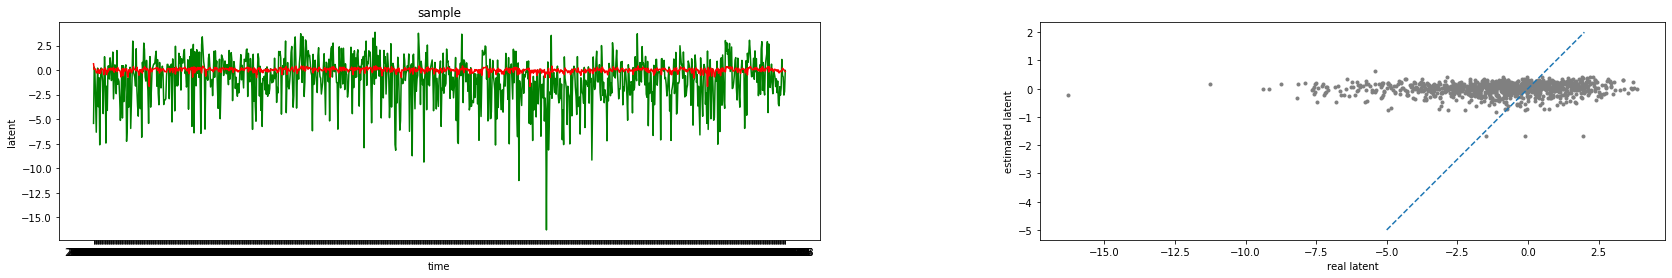

In [20]:
fig = plot_latent(train_dates, train_X, latent = train_y, ky=state_means, plot_type="r-", label=None, title='sample')

### 2. Heavy-tailed distribution model: SV-t model - LDS with Particle Filter

$$x_t = \phi x_{t-1} + w_t$$
$$y_t = \alpha + x_t + z_t$$
where $w_t \sim N(0,r)$, $x_0 \sim N(\mu_0,\sigma_0^2)$, $v_t \sim N(0,1)$, $\left\{{r_t}\right\}_{t\ge 0}$ is the log-returns on day t.

It is argued that real price data may have heavier tails which cannot be captured by the standard SV model with normal-distributed observation noise.

An extension of the linearized version of the SV model is to assume the observation noise, $z_t$, follows a student-t distribution with degrees of freedom, v. While the state equation remains unchanges, the observation equation is 
$$y_t = \alpha + x_t + z_t, z_t \sim t(v)$$



To implement EM algorithm, particle filter is used in E-step.

In [21]:
import scipy.stats as stats

In [50]:
class ParticleFiltering:

    def __init__(self, time, Nsamp, n_dim_state, n_dim_obs, transition_matrices = None, transition_covariance = None, observation_matrices = None,
                 observation_degree_of_freedom = None, transition_offsets = None, observation_offsets = None, initial_state_mean = None, initial_state_covariance = None):
        self.n_dim_state = n_dim_state
        self.n_dim_obs = n_dim_obs
        self.transition_matrices = transition_matrices
        self.transition_covariance = transition_covariance
        self.observation_matrices = observation_matrices
        self.observation_degree_of_freedom = observation_degree_of_freedom
        self.initial_state_mean = initial_state_mean
        self.initial_state_covariance = initial_state_covariance
        self.transition_offsets = transition_offsets
        self.observation_offsets = observation_offsets
        self.time = time
        self.Nsamp = Nsamp
         

    def particle_filter(self, data, Nsamp, seed=0):
        np.random.seed(seed)
        # placeholder
        self.est_z_mean = np.zeros(len(data)) * np.nan
        self.est_z_var = np.zeros(len(data)) * np.nan
        # initial conditions:
        self.est_z_mean[0] = self.initial_state_mean.copy()
        self.est_z_var[0] = self.initial_state_covariance.copy()

        # placeholder
        self.z_samp = np.zeros([Nsamp, len(data)])
        self.w = np.zeros([Nsamp, len(data)])
        
        ### create samples from distribution with initial conditions
        z_samp0 = self.initial_state_mean +self.transition_offsets + np.random.randn(Nsamp)*np.sqrt(self.initial_state_covariance[0])
        #print('z0:',z_samp0)
        ### propagate to time point n=1
        #print(self.transition_matrices.shape)
        #print(z_samp0.shape)
        z_samp = self.transition_matrices * z_samp0 +self.transition_offsets + np.random.randn(1) * np.sqrt(self.transition_covariance[0])
        #print(z_samp.shape)
        ### save those samples from n=1
        self.z_samp[:,0] = z_samp.copy()
        #print(self.z_samp)
        
        for nn in range(1, len(data)):
            
            ### compute the weights
            #print(data[nn-1])
            #print(type(data[nn-1]))
            w = self.compute_w(data[nn-1], z_samp)
            
            ### keep track of mean and variance of the weighted samples
            self.est_z_mean[nn-1] = np.sum(w * z_samp)
            self.est_z_var[nn-1] = np.sum(w * (z_samp - self.est_z_mean[nn-1]) ** 2)

            ### compute class assignments
            # sample from multinomial distribution with probabilities w
            k = np.random.multinomial(Nsamp, w)
            z_samp_new = np.repeat(z_samp, k)
            
            ### propagate and create samples at time point n+1 (using the reweighted particles)
            z_samp = np.zeros(Nsamp) * np.nan
            for ss in range(Nsamp):
                z_mean = self.transition_matrices * z_samp_new[ss]
                z_samp[ss] = z_mean + np.random.randn(1) * np.sqrt(self.transition_covariance[0])
                
            # save particles and weights
            self.w[:, nn-1] = w
            self.z_samp[:, nn] = z_samp
            
        ### track for last sample:
        w = self.compute_w(data[-1], z_samp)
        self.est_z_mean[-1] = np.sum(w * z_samp)
        self.est_z_var[-1] = np.sum(w * (z_samp - self.est_z_mean[-1]) ** 2)
        
        ### filtered state mean and covariance
        filtered_state_mean = self.est_z_mean
        filtered_state_covariance = self.est_z_var
        
        return filtered_state_mean, filtered_state_covariance
            

    def compute_w(self, data_nn, z_samp, seed=0):
        np.random.seed(seed)
        z_samp = z_samp.reshape(1,self.Nsamp)
        #print(z_samp.shape)
        w = np.zeros(z_samp.shape[1]) * np.nan
        #print(self.observation_matrices.shape)
        x = list(self.observation_matrices.dot(z_samp).ravel())
        #print(self.observation_degree_of_freedom)
        w = stats.t.pdf(x=data_nn,loc = x, df = 3,)
        w /= np.sum(w)
        return w
    
    def smooth(self, X):
        """
        Method that performs the Kalman Smoothing
        @param X: a numpy 2D array whose dimension is [n_example, self.n_dim_obs]
        @output: smoothed_state_means: a numpy 2D array whose dimension is [n_example, self.n_dim_state]
        @output: smoothed_state_covariances: a numpy 3D array whose dimension is [n_example, self.n_dim_state, self.n_dim_state]
        """
        
        # validate inputs
        n_example = len(X)
#         n_example, observed_dim = X.shape
#         assert observed_dim==self.n_dim_obs

        
        # run the forward path
        mu_list, v_list = self.particle_filter(X, Nsamp = self.Nsamp)
        #print(mu_list)
        #print(v_list)
        mu_list = mu_list.reshape(len(mu_list),1)
        v_list = v_list.reshape(len(v_list),1,1)
        
        # create holders for outputs
        smoothed_state_means = np.zeros( (n_example, self.n_dim_state) )
        smoothed_state_covariances = np.zeros( (n_example, self.n_dim_state, self.n_dim_state) )
        
        # init for EM
        self.j_n = []
        
        # last time step doesn't need to be updated
        smoothed_state_means[-1, :] = mu_list[-1, :]
        smoothed_state_covariances[-1, :, :] = v_list[-1, :, :]
        
        # run the backward path
        # it's zero-indexed and we don't need to update the last elements
        for i in range(n_example-2, -1, -1):
            # used to store intermediate results
            p_i = np.matmul(np.matmul(self.transition_matrices, v_list[i,:,:]), self.transition_matrices.T) + self.transition_covariance
            j_i = np.matmul(np.matmul(v_list[i,:,:], self.transition_matrices.T), np.linalg.inv(p_i))
            
            # canculate mu_bar and v_bar
            current_smoothed_mean = mu_list[i, :] + np.matmul(j_i, (smoothed_state_means[i+1, :] - np.matmul(self.transition_matrices, mu_list[i, :])))
            current_smoothed_covar = v_list[i,:] + np.matmul(np.matmul(j_i, ( smoothed_state_covariances[i+1, :, :] - p_i)), j_i.T)
            # propagate the holders
            smoothed_state_means[i, :] = current_smoothed_mean
            smoothed_state_covariances[i, :, :] = current_smoothed_covar
            # note that j_n is REVERSELY propagated from N-2 to 0 (zero-indexed)
            self.j_n.append(j_i)
        # add the last j_n
        p_N = np.matmul(np.matmul(self.transition_matrices, v_list[-1,:,:]), \
                        np.linalg.inv(self.transition_matrices)) + self.transition_covariance
        j_N = np.matmul(np.matmul(v_list[-1,:,:], self.transition_matrices.T), np.linalg.inv(p_N))
        self.j_n = list(reversed(self.j_n))
        self.j_n.append(j_N)
            
        return smoothed_state_means, smoothed_state_covariances
    
    def em(self, X, n_iter = 10):
        """
        Method that perform the EM algorithm to update the model parameters
        Note that in this exercise we ignore offsets
        @param X: a numpy 2D array whose dimension is [n_example, self.n_dim_obs]
        @param max_iter: an integer indicating how many iterations to run
        """
        # validate inputs have right dimensions
        n_example = len(X)
#         observed_dim
#         assert observed_dim==self.n_dim_obs
        
        # keep track of log posterior (use function calculate_posterior below)
        #self.avg_em_log_posterior = []

        # iterate through 
        for iter_num in range(n_iter):
            ### Expectation Step ###
            # run the forward and backward path
            smoothed_state_means, smoothed_state_covariances = self.smooth(X)
            #self.avg_em_log_posterior.append(np.nanmean(self.calculate_posterior(X, smoothed_state_means)))
            
            # propagate E[z_n], E[z_n z_{n-1}^T], E[z_n z_n^T]
            self.e_zn = []
            self.e_zn_znminus = []
            self.e_zn_zn = []
            for i in range(n_example):
                self.e_zn.append(smoothed_state_means[i])
                self.e_zn_zn.append(smoothed_state_covariances[i] + 
                                    np.outer(smoothed_state_means[i].T, smoothed_state_means[i]))
                # E[z_n z_{n-1}^T] only has n-1 elements
                if i != 0:
                    self.e_zn_znminus.append(np.matmul(self.j_n[i-1], smoothed_state_covariances[i]) + 
                                             np.outer(smoothed_state_means[i], smoothed_state_means[i-1].T) )
            
            ### Maximization Step ###
            ## need to update: initial states and initial covariance ##
            ##           transition matrix and transition covariance ##
            
            
            # update initial states and initial covariance
            self.initial_state_mean = smoothed_state_means[0, :]
            self.initial_state_covariance = smoothed_state_covariances[0, :]
            
            # update transition matrix and transition covariance
            ezy = np.sum(np.array(self.e_zn_znminus), 0)
            ezz = np.sum(np.array(self.e_zn_zn), 0)
            ezz_minus_n = ezz - self.e_zn_zn[-1]
            ezz_minus_1 = ezz - self.e_zn_zn[0]
            self.transition_matrices = np.matmul(ezy, np.linalg.inv(ezz_minus_n))
            ezy_a = np.matmul(ezy, self.transition_matrices.T)
            self.transition_covariance = (ezz_minus_1 - ezy_a - ezy_a.T + 
                                           np.matmul(np.matmul(self.transition_matrices, ezz_minus_n), 
                                                     self.transition_matrices.T))/(n_example-1)
            
            # update observation offsets
            n_timesteps = len(self.time)
            observation_offset = np.zeros(n_dim_obs)
            observation_matrix = self.observation_matrices
            for t in range(n_timesteps):
                observation_offset += (X[t]
                                       - np.dot(observation_matrix, smoothed_state_means[t]))
            self.observation_offsets = (1.0 / n_timesteps) * observation_offset
            
    #################################################################################
    #################################################################################
    #################################################################################
    def em_without_smooth(self, X, n_iter = 10):
        """
        Method that perform the EM algorithm to update the model parameters
        Note that in this exercise we ignore offsets
        @param X: a numpy 2D array whose dimension is [n_example, self.n_dim_obs]
        @param max_iter: an integer indicating how many iterations to run
        """
        # validate inputs have right dimensions
        n_example = len(X)
        
        # iterate through 
        for iter_num in range(n_iter):
            ### Expectation Step ###
            # run the forward and backward path
            filtered_state_means, filtered_state_covariances = self.particle_filter(X, Nsamp)
            #self.avg_em_log_posterior.append(np.nanmean(self.calculate_posterior(X, smoothed_state_means)))
            
            # propagate E[z_n], E[z_n z_{n-1}^T], E[z_n z_n^T]
            self.e_zn = []
            self.e_zn_znminus = []
            self.e_zn_zn = []
            for i in range(n_example):
                self.e_zn.append(filtered_state_means[i])
                self.e_zn_zn.append(filtered_state_covariances[i] + 
                                    np.outer(filtered_state_means[i].T, filtered_state_means[i]))
                # E[z_n z_{n-1}^T] only has n-1 elements
                if i != 0:
                    self.e_zn_znminus.append(np.dot(self.transition_matrices, filtered_state_covariances[i-1]) + 
                                             np.outer(filtered_state_means[i], filtered_state_means[i-1].T) )
            
            ### Maximization Step ###
            ## need to update: initial states and initial covariance ##
            ##           transition matrix and transition covariance ##
            
            
            # update initial states and initial covariance
            self.initial_state_mean = np.array(filtered_state_means[0])
            self.initial_state_covariance = np.array(filtered_state_covariances[0]).reshape(1,1)

            # update transition matrix and transition covariance
            ezy = np.sum(np.array(self.e_zn_znminus), 0)
            ezz = np.sum(np.array(self.e_zn_zn), 0)
            ezz_minus_n = ezz - self.e_zn_zn[-1]
            ezz_minus_1 = ezz - self.e_zn_zn[0]
            self.transition_matrices = np.matmul(ezy, np.linalg.inv(ezz_minus_n))
            ezy_a = np.matmul(ezy, self.transition_matrices.T)
            self.transition_covariance = (ezz_minus_1 - ezy_a - ezy_a.T + 
                                           np.matmul(np.matmul(self.transition_matrices, ezz_minus_n), 
                                                     self.transition_matrices.T))/(n_example-1)
            
            # update observation offsets
            n_timesteps = len(self.time)
            observation_offset = np.zeros(n_dim_obs)
            observation_matrix = self.observation_matrices
            for t in range(n_timesteps):
#                 observation_offset += (X[t]
#                                        - np.dot(observation_matrix, smoothed_state_means[t].reshape(1,1)))
                observation_offset += (X[t]
                                       - observation_matrix*filtered_state_means[t])[0]
            self.observation_offsets = (1.0 / n_timesteps) * observation_offset
    ##################################################################################
    
    def print_parameters(self, need_params=None):
        """
        Function that prints out the parameters for a Kalman Filter
        @param - kf_model : the model object
        @param - need_params : a list of string
        """
        if need_params is None:
            need_params = ['transition_matrices', 'observation_matrices', 'transition_offsets', 
                  'observation_offsets', 'transition_covariance', 
                  'observation_degree_of_freedom', 'initial_state_mean', 'initial_state_covariance']
        for param in need_params: 
            print("{0} = {1}\n".format(param, getattr(self, param)))
            
        

In [23]:
# Sampling
n_dim_state = 1
n_dim_obs = 1
time = train_dates
Nsamp = 1000
pf = ParticleFiltering(time = time, n_dim_state=n_dim_state, n_dim_obs=n_dim_obs, Nsamp = Nsamp)
# set paramters
pf.transition_matrices = np.eye(pf.n_dim_state)
pf.transition_covariance = np.eye(pf.n_dim_obs)
pf.observation_matrices = np.eye(pf.n_dim_state)
pf.observation_degree_of_freedom = 2
pf.initial_state_mean = np.zeros(pf.n_dim_state)
pf.initial_state_covariance = np.eye(pf.n_dim_state)
pf.transition_offsets = 0
pf.observation_offsets = 1
pf.time = time
# pf.em_vars = [ 'transition_matrices', 'transition_covariance', 'observation_offsets', 
#               'initial_state_mean','initial_state_covariance']


In [25]:
# pf.print_parameters()

##### with smoothing

In [26]:
pf.em(np.array(train_X), n_iter=100)
pf.print_parameters(need_params=None)

transition_matrices = [[0.50554823]]

observation_matrices = [[1.]]

transition_offsets = 0

observation_offsets = [-0.42565311]

transition_covariance = [[2.24939795]]

observation_degree_of_freedom = 2

initial_state_mean = [1.68580189]

initial_state_covariance = [[8.05624199e-32]]



In [29]:
state_means = predict('SV-t')
rmse = np.sqrt(mean_squared_error(train_y,state_means))
rmse

2.489738013385254

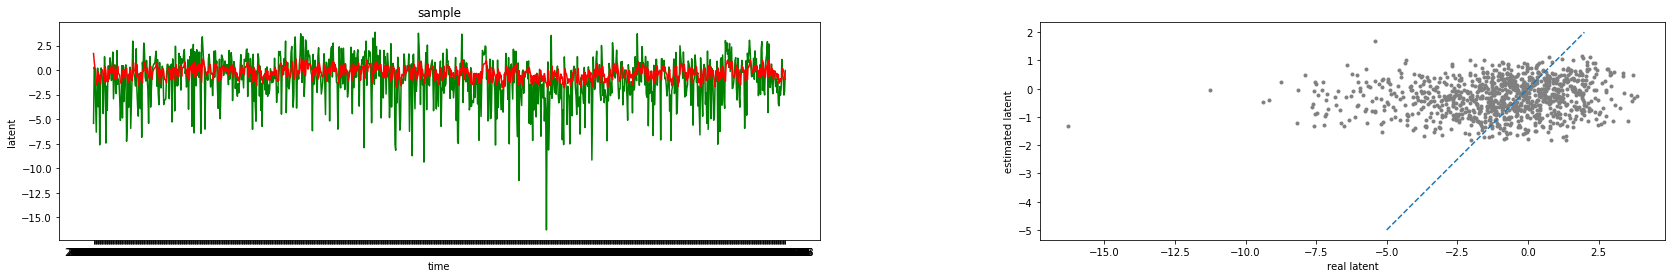

In [30]:
fig = plot_latent(train_dates, train_X, latent = train_y, ky=state_means, plot_type="r-", label=None, title='sample')

In [ ]:
################################################

In [146]:
smoothed_state_means, smoothed_state_covariances = pf.particle_filter(train_X,200)

In [169]:
initial_state_mean = pf.initial_state_mean
initial_state_covariance = pf.initial_state_covariance
transition_matrices = pf.transition_matrices
#observation_covariance = kf.observation_covariance
state_means = [float(initial_state_mean)]
#state_covariances = [float(initial_state_covariance)]
for i in range(len(smoothed_state_means[:-1])):
    state_means.append(float(transition_matrices*smoothed_state_means[i]))
    #state_covariances.append(float(pow(transition_matrices,2)*filter_state_covariances[i])+float(observation_covariance))

In [170]:
rmse = np.sqrt(mean_squared_error(train_y,state_means))
rmse

2.4649417669157345

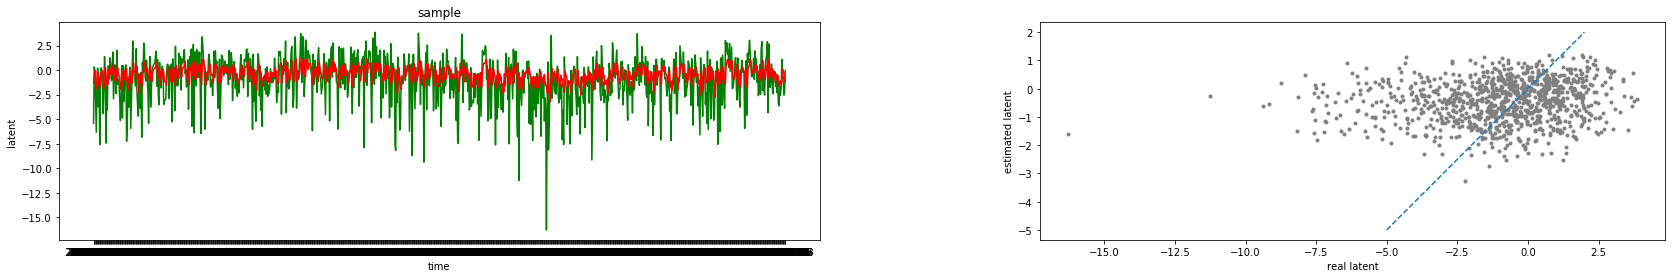

In [171]:
fig = plot_latent(train_dates, train_X, latent = train_y, ky=state_means, plot_type="r-", label=None, title='sample')

In [ ]:
###################################################################

##### without smoothing

In [33]:
# Sampling
n_dim_state = 1
n_dim_obs = 1
time = train_dates
Nsamp = 1000
pf = ParticleFiltering(time = time, n_dim_state=n_dim_state, n_dim_obs=n_dim_obs, Nsamp = Nsamp)
# set paramters
pf.transition_matrices = np.eye(pf.n_dim_state)
pf.transition_covariance = np.eye(pf.n_dim_obs)
pf.observation_matrices = np.eye(pf.n_dim_state)
pf.observation_degree_of_freedom = 2
pf.initial_state_mean = np.zeros(pf.n_dim_state)
pf.initial_state_covariance = np.eye(pf.n_dim_state)
pf.transition_offsets = 0
pf.observation_offsets = 1
pf.time = time
# pf.em_vars = [ 'transition_matrices', 'transition_covariance', 'observation_offsets', 
#               'initial_state_mean','initial_state_covariance']



In [34]:
pf.em_without_smooth(np.array(train_X), n_iter=100)
pf.print_parameters(need_params=None)

transition_matrices = [[0.45501992]]

observation_matrices = [[1.]]

transition_offsets = 0

observation_offsets = [-0.485191]

transition_covariance = [[2.52994734]]

observation_degree_of_freedom = 2

initial_state_mean = 1.624869635078734

initial_state_covariance = [[6.07127074e-31]]



In [35]:
state_means = predict('SV-t')
rmse = np.sqrt(mean_squared_error(train_y,state_means))
rmse

2.49457287295135

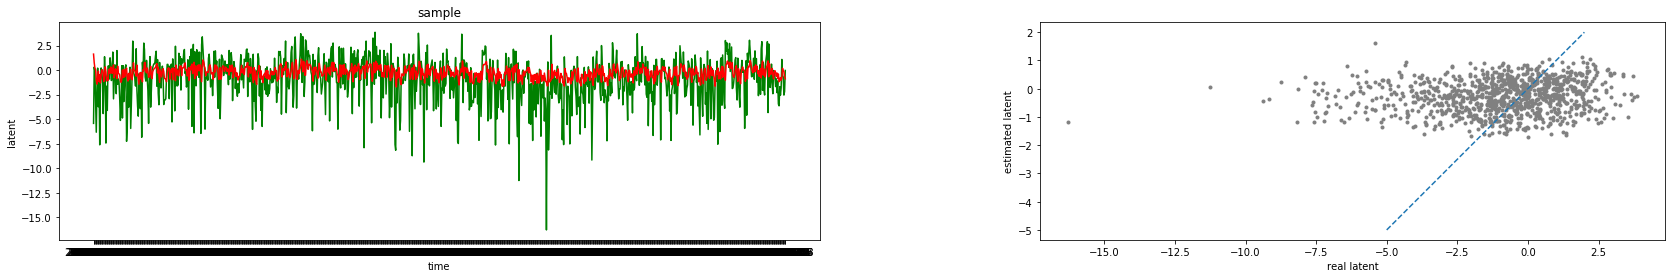

In [36]:
fig = plot_latent(train_dates, train_X, latent = train_y, ky=state_means, plot_type="r-", label=None, title='sample')

#### Artificial Sampled Data

In [57]:
transition_matrices = 0.75

observation_matrices = 1

transition_offsets = 0

observation_offsets = 1

transition_covariance = 1

observation_degree_of_freedom = 2

initial_state_mean = 0

initial_state_covariance = 1

latents = np.zeros(1000)
latents[0] = initial_state_mean + np.random.randn(1)*np.sqrt(initial_state_covariance)
observations = np.zeros(1000)
observations[0] = observation_matrices*latents[0]+observation_offsets + stats.t.rvs(df = 2, size = 1)

for i in range(1,1000):
    latents[i] = transition_matrices * latents[i-1] + np.random.randn(1)*np.sqrt(transition_covariance)
    observations[i] = observation_matrices*latents[i]+ observation_offsets + stats.t.rvs(df = 2, size = 1)
    

In [173]:
# Sampling
n_dim_state = 1
n_dim_obs = 1
kf = KalmanFilter(n_dim_state=n_dim_state, n_dim_obs=n_dim_obs)
# set paramters
kf.transition_matrices = np.eye(kf.n_dim_state)
kf.transition_covariance = np.eye(kf.n_dim_obs)
kf.observation_matrices = np.eye(kf.n_dim_state)
kf.observation_covariance = np.eye(kf.n_dim_obs)
kf.initial_state_mean = np.zeros(kf.n_dim_state)
kf.initial_state_covariance = np.eye(kf.n_dim_state)
kf.transition_offsets = 0
kf.observation_offsets = 1
kf.em_vars = [ 'transition_matrices', 'transition_covariance', 'observation_covariance', 'observation_offsets', 
              'initial_state_mean','initial_state_covariance']

In [174]:
kf.em(observations, n_iter=50)
print_parameters(kf, need_params=None)

transition_matrices = [[0.47618968]]

observation_matrices = [[1.]]

transition_offsets = [0]

observation_offsets = [0.94505482]

transition_covariance = [[3.08426195]]

observation_covariance = [[12.21031274]]

initial_state_mean = [1.67698125]

initial_state_covariance = [[0.12868818]]



In [175]:
smoothed_state_means, smoothed_state_covariances = kf.filter(observations)

In [178]:
initial_state_mean = kf.initial_state_mean
initial_state_covariance = kf.initial_state_covariance
transition_matrices = kf.transition_matrices
#observation_covariance = kf.observation_covariance
state_means = [float(initial_state_mean)]
#state_covariances = [float(initial_state_covariance)]
for i in range(len(smoothed_state_means[:-1])):
    state_means.append(float(transition_matrices*smoothed_state_means[i]))
    #state_covariances.append(float(pow(transition_matrices,2)*filter_state_covariances[i])+float(observation_covariance))

In [180]:
rmse = np.sqrt(mean_squared_error(observations,state_means))
rmse

4.102743439579028

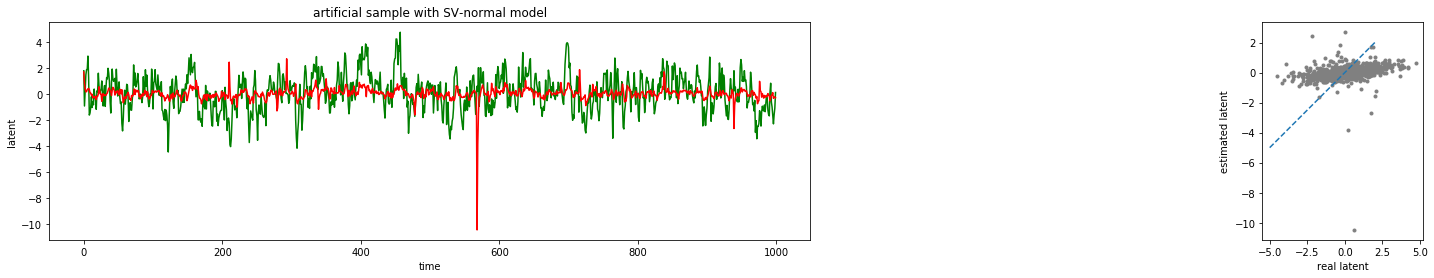

In [181]:
fig = plot_latent(range(1000), observations, latent = latents, ky=state_means, plot_type="r-", label=None, title='artificial sample with SV-normal model')

In [182]:
# Sampling
n_dim_state = 1
n_dim_obs = 1
time = range(1000)
Nsamp = 1000
pf = ParticleFiltering(time = time, n_dim_state=n_dim_state, n_dim_obs=n_dim_obs, Nsamp = Nsamp)
# set paramters
pf.transition_matrices = np.eye(pf.n_dim_state)
pf.transition_covariance = np.eye(pf.n_dim_obs)
pf.observation_matrices = np.eye(pf.n_dim_state)
pf.observation_degree_of_freedom = 2
pf.initial_state_mean = np.zeros(pf.n_dim_state)
pf.initial_state_covariance = np.eye(pf.n_dim_state)
pf.transition_offsets = 0
pf.observation_offsets = 1
pf.time = time
# pf.em_vars = [ 'transition_matrices', 'transition_covariance', 'observation_offsets', 
#               'initial_state_mean','initial_state_covariance']



In [184]:
pf.em(np.array(observations), n_iter=50)
pf.print_parameters(need_params=None)

transition_matrices = [[0.8431256]]

observation_matrices = [[1.]]

transition_offsets = 0

observation_offsets = [0.01358515]

transition_covariance = [[0.8786558]]

observation_degree_of_freedom = 2

initial_state_mean = [3.32570942]

initial_state_covariance = [[9.08765919e-10]]



In [185]:
smoothed_state_means, smoothed_state_covariances = pf.particle_filter(observations,1000)

In [186]:
initial_state_mean = pf.initial_state_mean
initial_state_covariance = pf.initial_state_covariance
transition_matrices = pf.transition_matrices
#observation_covariance = kf.observation_covariance
state_means = [float(initial_state_mean)]
#state_covariances = [float(initial_state_covariance)]
for i in range(len(smoothed_state_means[:-1])):
    state_means.append(float(transition_matrices*smoothed_state_means[i]))
    #state_covariances.append(float(pow(transition_matrices,2)*filter_state_covariances[i])+float(observation_covariance))

In [187]:
rmse = np.sqrt(mean_squared_error(observations,state_means))
rmse

3.9388396087342405

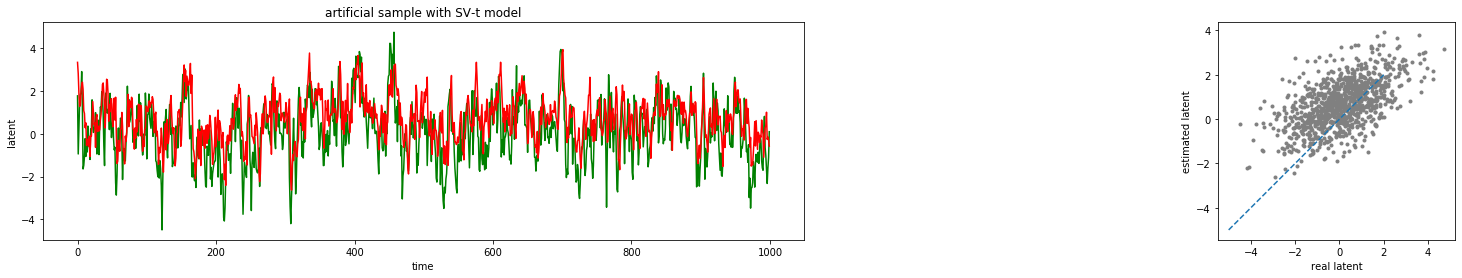

In [188]:
fig = plot_latent(range(1000), observations, latent = latents, ky=state_means, plot_type="r-", label=None, title='artificial sample with SV-t model')

In [56]:
# Sampling
n_dim_state = 1
n_dim_obs = 1
time = range(1000)
Nsamp = 1000
pf = ParticleFiltering(time = time, n_dim_state=n_dim_state, n_dim_obs=n_dim_obs, Nsamp = Nsamp)
# set paramters
pf.transition_matrices = np.eye(pf.n_dim_state)
pf.transition_covariance = np.eye(pf.n_dim_obs)
pf.observation_matrices = np.eye(pf.n_dim_state)
pf.observation_degree_of_freedom = 2
pf.initial_state_mean = np.zeros(pf.n_dim_state)
pf.initial_state_covariance = np.eye(pf.n_dim_state)
pf.transition_offsets = 0
pf.observation_offsets = 1
pf.time = time
# pf.em_vars = [ 'transition_matrices', 'transition_covariance', 'observation_offsets', 
#               'initial_state_mean','initial_state_covariance']




In [58]:
pf.em_without_smooth(np.array(observations), n_iter=50)
pf.print_parameters(need_params=None)

transition_matrices = [[0.81437082]]

observation_matrices = [[1.]]

transition_offsets = 0

observation_offsets = [0.13274325]

transition_covariance = [[1.06242292]]

observation_degree_of_freedom = 2

initial_state_mean = 3.0866955713511004

initial_state_covariance = [[2.61594661e-10]]



In [59]:
smoothed_state_means, smoothed_state_covariances = pf.particle_filter(observations,1000)

In [60]:
initial_state_mean = pf.initial_state_mean
initial_state_covariance = pf.initial_state_covariance
transition_matrices = pf.transition_matrices
#observation_covariance = kf.observation_covariance
state_means = [float(initial_state_mean)]
#state_covariances = [float(initial_state_covariance)]
for i in range(len(smoothed_state_means[:-1])):
    state_means.append(float(transition_matrices*smoothed_state_means[i]))
    #state_covariances.append(float(pow(transition_matrices,2)*filter_state_covariances[i])+float(observation_covariance))

In [61]:
rmse = np.sqrt(mean_squared_error(observations,state_means))
rmse

3.9391435080716177

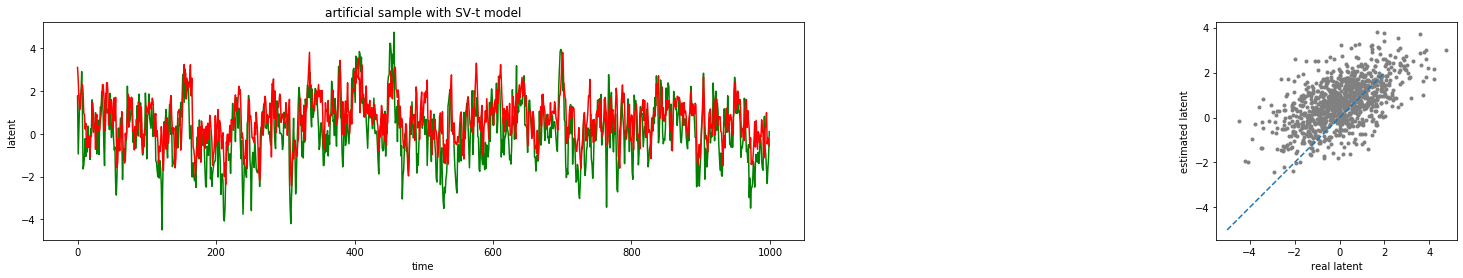

In [62]:
fig = plot_latent(range(1000), observations, latent = latents, ky=state_means, plot_type="r-", label=None, title='artificial sample with SV-t model')

### 3. Evaluation for stocks

In [78]:
def evaluation(data, proxy, model_name):
    ## compute proxy for volatility
    #proxy = [pow((y_t[i] - sum(y_t)/len(y_t)),2) for i in range(len(y_t))]
    #print(proxy)
    ## compute predicted volatility
    if model_name == 'SV':
        smoothed_state_means, smoothed_state_covariances = kf.filter(data)
        pred = np.array(smoothed_state_means)
    if model_name == 'SV-t':
        smoothed_state_means, smoothed_state_covariances = pf.smooth(data)
        pred = np.array(smoothed_state_means)
    if model_name == 'GARCH':
        pass
    
    rmse = np.sqrt(mean_squared_error(proxy,pred))
    mae = mean_absolute_error(proxy,pred)
    
    return rmse, mae

In [25]:
evaluation(data = train_X, proxy = train_y, model_name = 'SV')

(1.484028504046699, 1.1269233719603213)

In [26]:
evaluation(data = test_X, proxy = test_y, model_name = 'SV')

(1.4609837638440046, 1.119125159248623)

In [212]:
evaluation(data = train_X, proxy = train_y, model_name = 'SV-t')

(3.179374918161276, 1.1629252177010256)

In [213]:
evaluation(data = test_X, proxy = test_y, model_name = 'SV-t')

(3.9019015532475168, 1.2793183182700416)

### Looping for different stocks

In [39]:
# import os
# import sys
# fileList = os.listdir('stock-data-dow-jones')
# fileList

In [47]:
# fileList = os.listdir('stock-data-dow-jones')
# pathlist = []
# for file in fileList:
#     path = os.path.join('stock-data-dow-jones', file)
#     pathlist.append(path)

In [40]:
def DataProcessing(path):
    data = pd.read_csv(path, index_col = 0)
    data['log_return'] = 0
    data['y_t'] = 0
    dates = data.index
    
    for i,date in enumerate(dates[1:]):
        close = data.loc[date, 'close']
        prev_close = data.loc[dates[i],'close']
        data.loc[date, 'log_return'] = 100*np.log(close/prev_close)
        data.loc[date, 'y_t'] = 2*np.log(max(abs(data.loc[date, 'log_return']),np.e**(-10)))
    
    y_t = data.y_t.tolist()
    log_return = data.log_return.tolist()
    proxy = np.log([pow((log_return[i] - sum(log_return)/len(log_return)),2) for i in range(len(y_t))])
        
    train_size = int(len(y_t)*0.8)
    train_X, train_y, train_dates = y_t[:train_size], proxy[:train_size],dates[:train_size]
    test_X, test_y, test_dates = y_t[train_size:], proxy[train_size:], dates[train_size:]
    
    return train_X, train_y, train_dates, test_X, test_y, test_dates, proxy
 

In [41]:
def initialKF():
    n_dim_state = 1
    n_dim_obs = 1
    kf = KalmanFilter(n_dim_state=n_dim_state, n_dim_obs=n_dim_obs)
    # set paramters
    kf.transition_matrices = np.eye(kf.n_dim_state)
    kf.transition_covariance = np.eye(kf.n_dim_obs)
    kf.observation_matrices = np.eye(kf.n_dim_state)
    kf.observation_covariance = np.eye(kf.n_dim_obs)
    kf.initial_state_mean = np.zeros(kf.n_dim_state)
    kf.initial_state_covariance = np.eye(kf.n_dim_state)
    kf.transition_offsets = 0
    kf.observation_offsets = 1
    kf.em_vars = [ 'transition_matrices', 'transition_covariance', 'observation_covariance', 'observation_offsets', 
              'initial_state_mean','initial_state_covariance']
    
    return kf

In [42]:
def initialPF():
    n_dim_state = 1
    n_dim_obs = 1
    time = train_dates
    Nsamp = 1000
    pf = ParticleFiltering(time = time, n_dim_state=n_dim_state, n_dim_obs=n_dim_obs, Nsamp = Nsamp)
    # set paramters
    pf.transition_matrices = np.eye(pf.n_dim_state)
    pf.transition_covariance = np.eye(pf.n_dim_obs)
    pf.observation_matrices = np.eye(pf.n_dim_state)
    pf.observation_degree_of_freedom = 2
    pf.initial_state_mean = np.zeros(pf.n_dim_state)
    pf.initial_state_covariance = np.eye(pf.n_dim_state)
    pf.transition_offsets = 0
    pf.observation_offsets = 1
    pf.time = time
# pf.em_vars = [ 'transition_matrices', 'transition_covariance', 'observation_offsets', 
#               'initial_state_mean','initial_state_covariance']

    return pf

In [43]:
def plotLatent(proxy, train_pred, test_pred, title):
    fout_index=np.linspace(len(train_X), len(proxy), num=len(test_pred))
    fin_index=np.linspace(0, len(train_X)-1, num=len(train_pred))
    
    plt.figure(figsize = (20,5))
    plt.plot(proxy,label='volatility proxy')
#     plt.fill_between(fin_index, train_means - np.sqrt(train_covariances),
#                            train_means + np.sqrt(train_covariances), color='orange', alpha=.5)
    plt.plot(fin_index,train_pred,color='orange', label='in-sample estimated latent')
#     plt.fill_between(fout_index, test_means - np.sqrt(test_covariances),
#                            test_means + np.sqrt(test_covariances), color='g', alpha=.5)
    plt.plot(fout_index,test_pred,color='g', label='out-of-sample estimated latent')
    plt.legend(loc='best', fontsize=15)
    plt.title(title)


In [44]:
def scatterLatent(train_y,train_state_means,test_y,test_state_means,title):
    plt.figure(figsize = (5,5))
    plt.plot(train_y, train_state_means, '.', color='k')
    plt.plot(test_y, test_state_means, '.', color='grey')
    plt.plot([-5, 2], [-5, 2], linestyle='--')
    plt.xlabel('real latent')
    plt.ylabel('estimated latent')
    plt.title(title)

In [45]:
['AAPL','KO','GS','HD','JNJ','WMT']

['AAPL', 'KO', 'GS', 'HD', 'JNJ', 'WMT']

stock-data-dow-jones/AAPL.csv
2.555629678464344 2.555629678464344
2.6285885506723803 1.8047353767047787
2.4643043232908446 2.4643043232908446
2.593782421054371 1.8417972310937143
--------------------------------------------------------------
stock-data-dow-jones/KO.csv
3.0269636766973558 3.0269636766973558
2.737983588204771 1.9925440926800937
2.4546960924903303 2.4546960924903303
2.356254525012097 1.758369781680476
--------------------------------------------------------------
stock-data-dow-jones/GS.csv
2.441845945882341 2.441845945882341
2.647175950907371 1.901316463955938
2.3896904137364494 2.3896904137364494
2.6418019654362195 1.9356503769422402
--------------------------------------------------------------
stock-data-dow-jones/HD.csv
2.6047196452809156 2.6047196452809156
2.7463891512511345 1.9848435731199279
2.368821247686483 2.368821247686483
2.5373629571248846 1.9196650818085372
--------------------------------------------------------------
stock-data-dow-jones/JNJ.csv
2.8076466

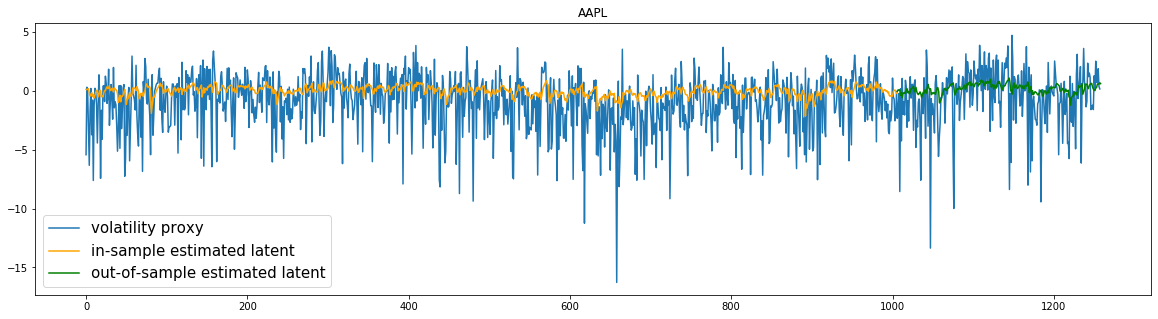

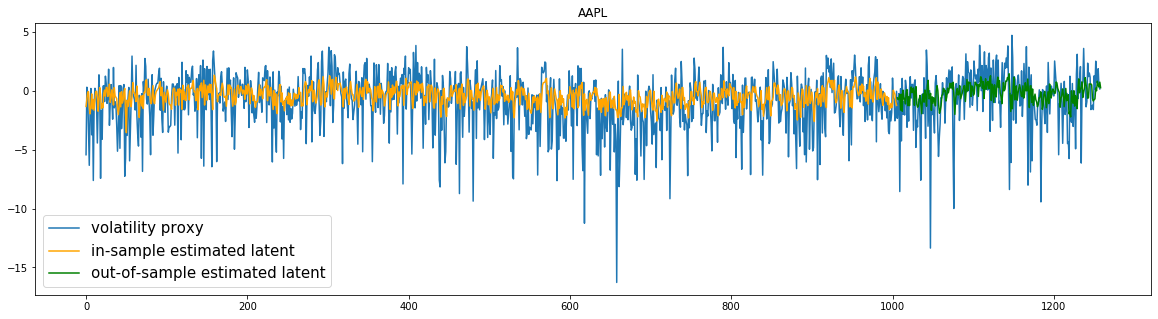

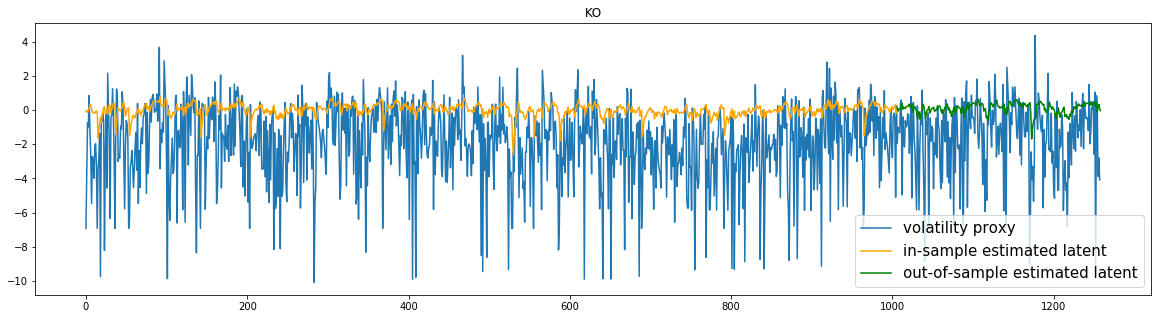

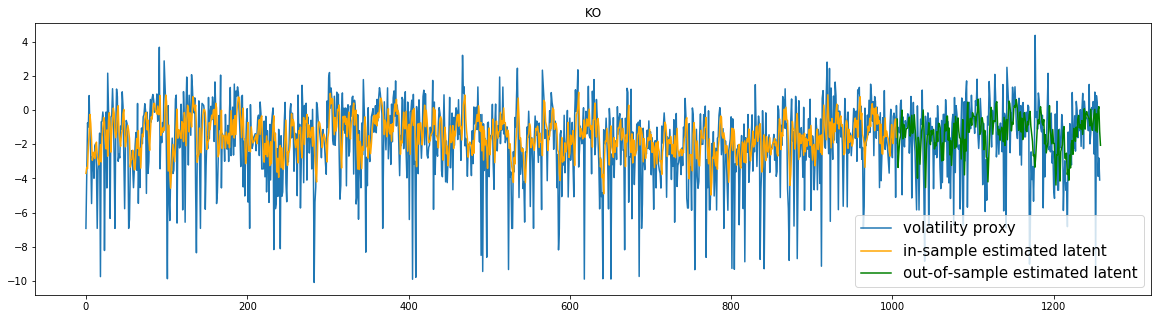

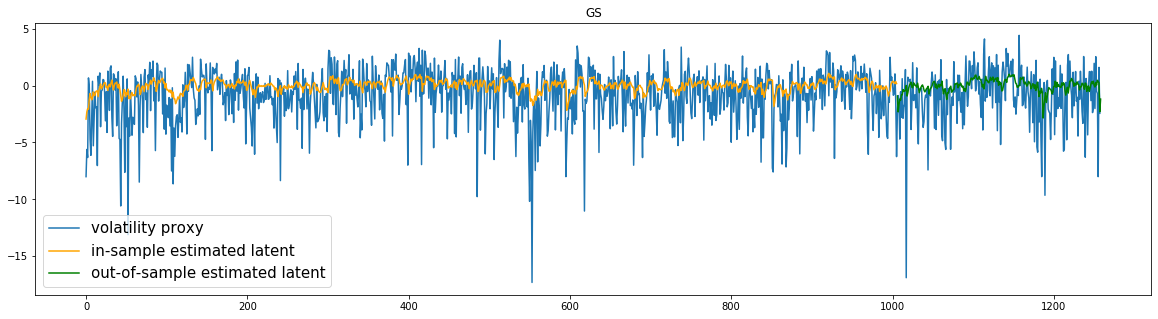

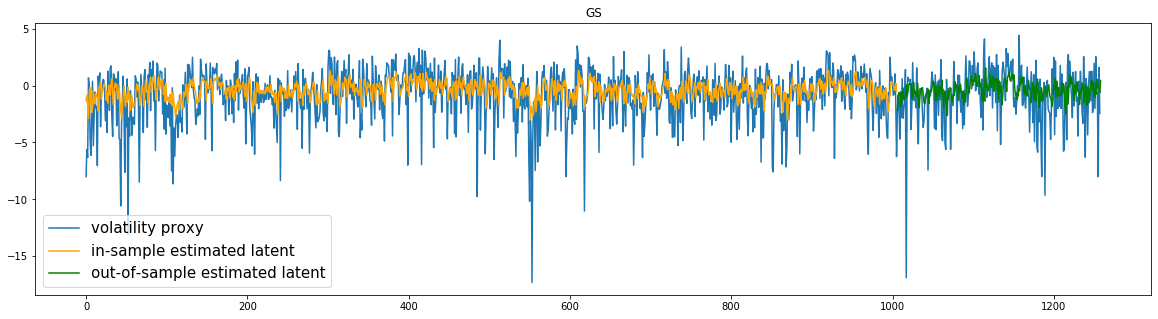

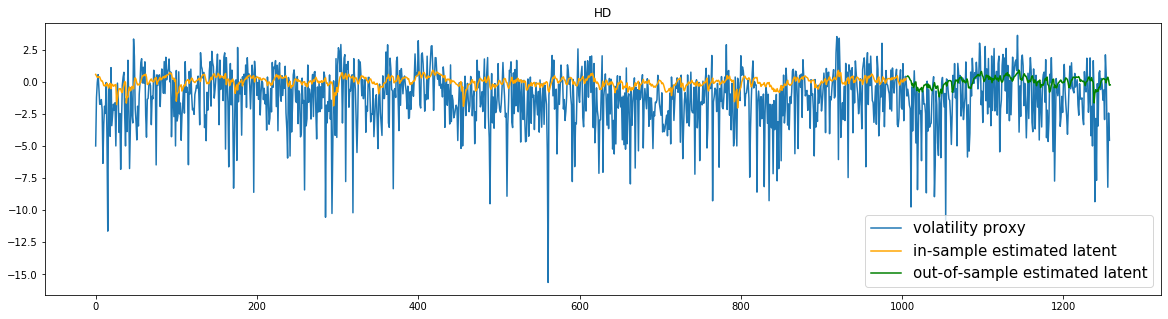

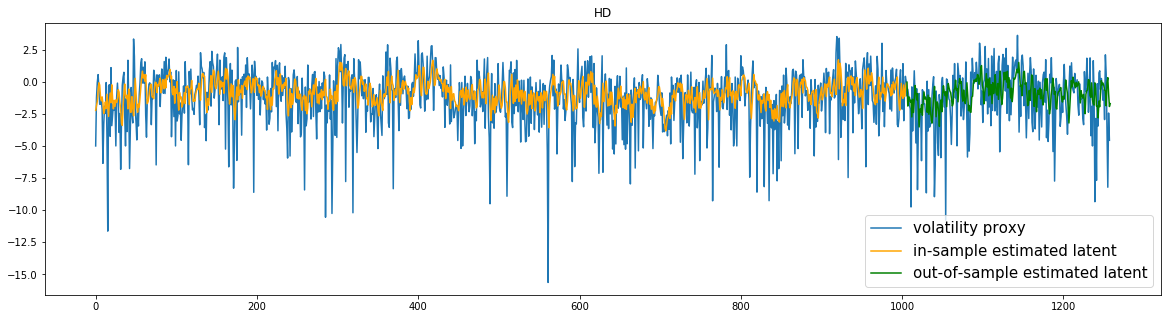

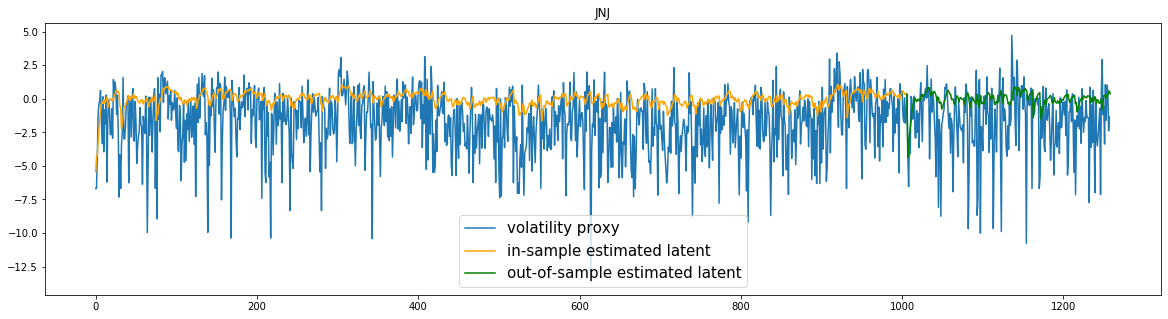

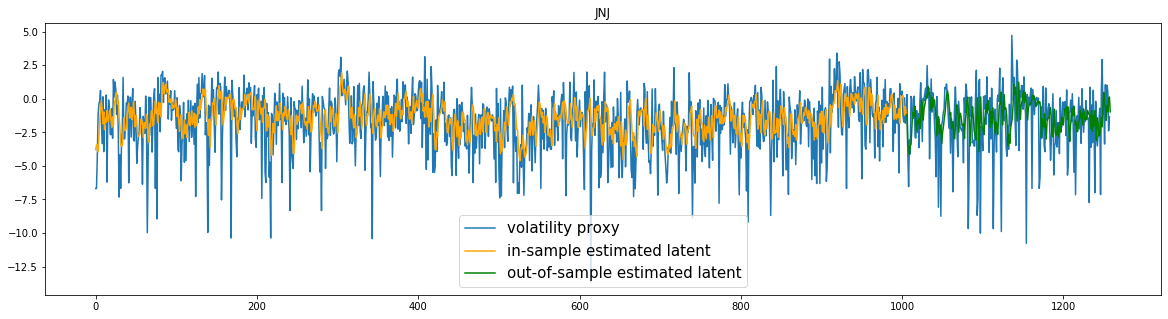

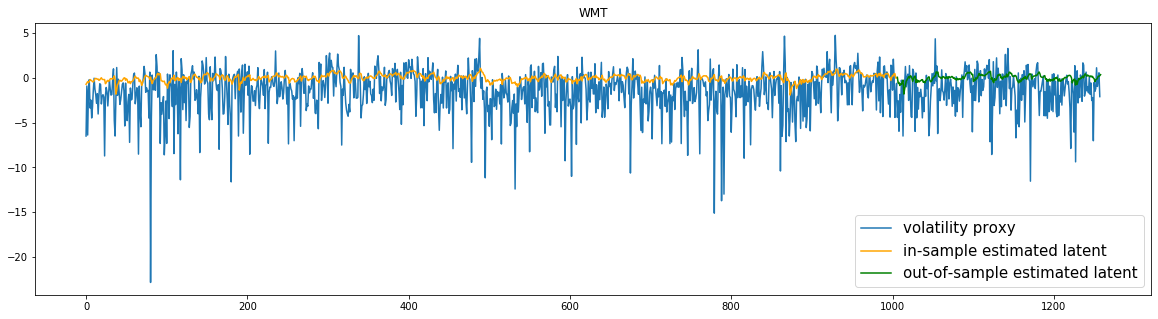

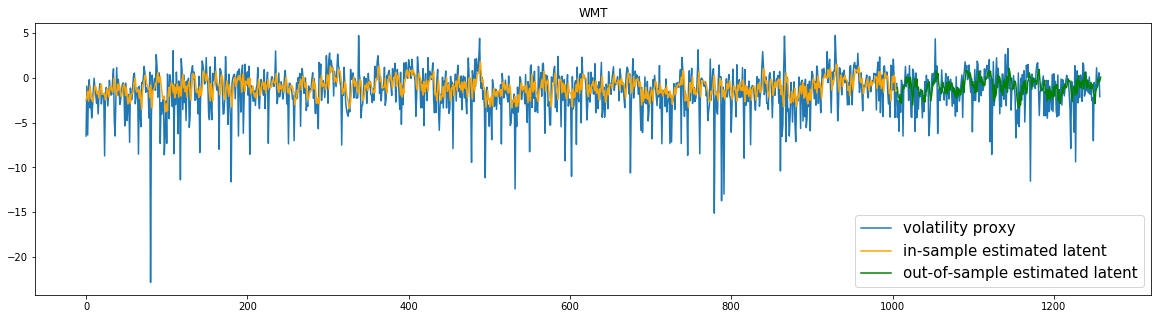

In [55]:
for name in ['AAPL','KO','GS','HD','JNJ','WMT']:
    path =  'stock-data-dow-jones/'+name+'.csv'
    print(path)
    train_X, train_y, train_dates, test_X, test_y, test_dates, proxy = DataProcessing(path)
    #train
    kf = initialKF()
    kf.em(train_X, n_iter=100)
    #predict train
    transition_matrices = kf.transition_matrices
    initial_state_mean = kf.initial_state_mean
    initial_state_covariance = kf.initial_state_covariance
    train_state_means, train_state_covariances = kf.filter(train_X)
    train_state_predicts = [float(initial_state_mean)]
    for i in range(len(train_state_means[:-1])):
        train_state_predicts.append(float(transition_matrices*train_state_means[i]))
    #predict test
    initial_state_mean = train_state_means[-1]
    initial_state_covariance = train_state_covariances[-1]
    test_state_means, test_state_covariances = kf.filter(test_X)
    test_state_predicts = [float(initial_state_mean)]
    for i in range(len(test_state_means[:-1])):
        test_state_predicts.append(float(transition_matrices*test_state_means[i]))
    train_rmse = np.sqrt(mean_squared_error(train_y,train_state_predicts))
    train_mae = mean_absolute_error(train_y,train_state_predicts)
    test_rmse = np.sqrt(mean_squared_error(test_y,test_state_predicts))
    test_mae = mean_absolute_error(test_y,test_state_predicts)
    print(train_rmse, train_rmse)
    print(test_rmse, test_mae)
    plotLatent(proxy, train_state_predicts, test_state_predicts, title = name)
    #scatterLatent(train_y,train_state_means,test_y,test_state_means,title=name)
    
    #train
    pf = initialPF()
    pf.em(train_X, n_iter=100)
    #predict train
    transition_matrices = pf.transition_matrices
    initial_state_mean = pf.initial_state_mean
    initial_state_covariance = pf.initial_state_covariance
    train_state_means, train_state_covariances = pf.particle_filter(train_X, pf.Nsamp)
    train_state_predicts = [float(initial_state_mean)]
    for i in range(len(train_state_means[:-1])):
        train_state_predicts.append(float(transition_matrices*train_state_means[i]))
    #predict test
    initial_state_mean = train_state_means[-1]
    initial_state_covariance = train_state_covariances[-1]
    test_state_means, test_state_covariances = pf.particle_filter(test_X, pf.Nsamp)
    test_state_predicts = [float(initial_state_mean)]
    for i in range(len(test_state_means[:-1])):
        test_state_predicts.append(float(transition_matrices*test_state_means[i]))
    train_rmse = np.sqrt(mean_squared_error(train_y,train_state_predicts))
    train_mae = mean_absolute_error(train_y,train_state_predicts)
    test_rmse = np.sqrt(mean_squared_error(test_y,test_state_predicts))
    test_mae = mean_absolute_error(test_y,test_state_predicts)
    print(train_rmse, train_rmse)
    print(test_rmse, test_mae)
    plotLatent(proxy, train_state_predicts, test_state_predicts, title = name)
    
    print('--------------------------------------------------------------')

In [73]:
for name in ['AAPL','KO','GS','HD','JNJ','WMT']:
    path =  'stock-data-dow-jones/'+name+'.csv'
    print(path)
    
    data = pd.read_csv(path, index_col = 0)
    data['log_return'] = 0
    data['y_t'] = 0
    dates = data.index
    
    for i,date in enumerate(dates[1:]):
        close = data.loc[date, 'close']
        prev_close = data.loc[dates[i],'close']
        data.loc[date, 'log_return'] = 100*np.log(close/prev_close)
        data.loc[date, 'y_t'] = 2*np.log(max(abs(data.loc[date, 'log_return']),np.e**(-10)))
    
    y_t = data.y_t.tolist()
    log_return = data.log_return.tolist()
    proxy = np.log([pow((log_return[i] - sum(log_return)/len(log_return)),2) for i in range(len(y_t))])
    print(np.std(y_t),np.std(proxy))

stock-data-dow-jones/AAPL.csv
2.5721002392286985 2.428084051427668
stock-data-dow-jones/KO.csv
2.867414216487567 2.3029451027457357
stock-data-dow-jones/GS.csv
2.4564752174690065 2.3912364515947457
stock-data-dow-jones/HD.csv
2.707054429032207 2.31418212719219
stock-data-dow-jones/JNJ.csv
2.6955549893927486 2.33062701778795
stock-data-dow-jones/WMT.csv
2.4668941136858145 2.492303813032525


### Marginal Analysis

In [63]:
def SampleProcessing(data):
    dates = range(len(data))
    log_return = np.exp(data)
    proxy = np.log([pow((log_return[i] - sum(log_return)/len(log_return)),2) for i in range(len(log_return))])
        
    train_size = int(len(data)*0.8)
    train_X, train_y, train_dates = data[:train_size], proxy[:train_size],dates[:train_size]
    test_X, test_y, test_dates = data[train_size:], proxy[train_size:], dates[train_size:]
    
    return train_X, train_y, train_dates, test_X, test_y, test_dates, proxy

#### to the volatility of sample

In [71]:
transition_matrices = 0.75
observation_matrices = 1
transition_offsets = 0
observation_offsets = 1
transition_covariance = 1
observation_degree_of_freedom = 2
initial_state_mean = 0
initial_state_covariance = 1
latents = np.zeros(1000)
latents[0] = initial_state_mean + np.random.randn(1)*np.sqrt(initial_state_covariance)
observations_1 = np.zeros(1000)
observations_2 = np.zeros(1000)
observations_3 = np.zeros(1000)
observations_4 = np.zeros(1000)
observations_5 = np.zeros(1000)
observations_6 = np.zeros(1000)
t_noise = stats.t.rvs(df = 2, size = 1000)

observations_1[0] = observation_matrices*latents[0]+observation_offsets + t_noise[0]*0.25
for i in range(1,1000):
    latents[i] = transition_matrices * latents[i-1] + np.random.randn(1)*np.sqrt(transition_covariance)
    observations_1[i] = observation_matrices*latents[i]+ observation_offsets + t_noise[i]*0.25

observations_2[0] = observation_matrices*latents[0]+observation_offsets + t_noise[0]*0.5
for i in range(1,1000):
    latents[i] = transition_matrices * latents[i-1] + np.random.randn(1)*np.sqrt(transition_covariance)
    observations_2[i] = observation_matrices*latents[i]+ observation_offsets + t_noise[i]*0.5

observations_3[0] = observation_matrices*latents[0]+observation_offsets + t_noise[0]*0.75
for i in range(1,1000):
    latents[i] = transition_matrices * latents[i-1] + np.random.randn(1)*np.sqrt(transition_covariance)
    observations_3[i] = observation_matrices*latents[i]+ observation_offsets + t_noise[i]*0.75

observations_4[0] = observation_matrices*latents[0]+observation_offsets + t_noise[0]
for i in range(1,1000):
    latents[i] = transition_matrices * latents[i-1] + np.random.randn(1)*np.sqrt(transition_covariance)
    observations_4[i] = observation_matrices*latents[i]+ observation_offsets + t_noise[i]

observations_5[0] = observation_matrices*latents[0]+observation_offsets + t_noise[0]*1.25
for i in range(1,1000):
    latents[i] = transition_matrices * latents[i-1] + np.random.randn(1)*np.sqrt(transition_covariance)
    observations_5[i] = observation_matrices*latents[i]+ observation_offsets + t_noise[i]*1.25

observations_6[0] = observation_matrices*latents[0]+observation_offsets + t_noise[0]*1.5
for i in range(1,1000):
    latents[i] = transition_matrices * latents[i-1] + np.random.randn(1)*np.sqrt(transition_covariance)
    observations_6[i] = observation_matrices*latents[i]+ observation_offsets + t_noise[i]*1.5



In [72]:
for observations in [observations_1,observations_2,observations_3,observations_4,observations_5,observations_6]:
    train_X, train_y, train_dates, test_X, test_y, test_dates, proxy = SampleProcessing(observations)

    #train
    kf = initialKF()
    kf.em(train_X, n_iter=100)
    #predict train
    transition_matrices = kf.transition_matrices
    initial_state_mean = kf.initial_state_mean
    initial_state_covariance = kf.initial_state_covariance
    train_state_means, train_state_covariances = kf.filter(train_X)
    train_state_predicts = [float(initial_state_mean)]
    for i in range(len(train_state_means[:-1])):
        train_state_predicts.append(float(transition_matrices*train_state_means[i]))
    #predict test
    initial_state_mean = train_state_means[-1]
    initial_state_covariance = train_state_covariances[-1]
    test_state_means, test_state_covariances = kf.filter(test_X)
    test_state_predicts = [float(initial_state_mean)]
    for i in range(len(test_state_means[:-1])):
        test_state_predicts.append(float(transition_matrices*test_state_means[i]))
    train_rmse = np.sqrt(mean_squared_error(train_y,train_state_predicts))
    train_mae = mean_absolute_error(train_y,train_state_predicts)
    test_rmse = np.sqrt(mean_squared_error(test_y,test_state_predicts))
    test_mae = mean_absolute_error(test_y,test_state_predicts)
    print(train_rmse, train_rmse)
    print(test_rmse, test_mae)
    #plotLatent(proxy, train_state_predicts, test_state_predicts, title = name)
    #scatterLatent(train_y,train_state_means,test_y,test_state_means,title=name)
    
    #train
    pf = initialPF()
    pf.em(train_X, n_iter=100)
    #predict train
    transition_matrices = pf.transition_matrices
    initial_state_mean = pf.initial_state_mean
    initial_state_covariance = pf.initial_state_covariance
    train_state_means, train_state_covariances = pf.particle_filter(train_X, pf.Nsamp)
    train_state_predicts = [float(initial_state_mean)]
    for i in range(len(train_state_means[:-1])):
        train_state_predicts.append(float(transition_matrices*train_state_means[i]))
    #predict test
    initial_state_mean = train_state_means[-1]
    initial_state_covariance = train_state_covariances[-1]
    test_state_means, test_state_covariances = pf.particle_filter(test_X, pf.Nsamp)
    test_state_predicts = [float(initial_state_mean)]
    for i in range(len(test_state_means[:-1])):
        test_state_predicts.append(float(transition_matrices*test_state_means[i]))
    train_rmse = np.sqrt(mean_squared_error(train_y,train_state_predicts))
    train_mae = mean_absolute_error(train_y,train_state_predicts)
    test_rmse = np.sqrt(mean_squared_error(test_y,test_state_predicts))
    test_mae = mean_absolute_error(test_y,test_state_predicts)
    print(train_rmse, train_rmse)
    print(test_rmse, test_mae)
    #plotLatent(proxy, train_state_predicts, test_state_predicts, title = name)
    
    print('--------------------------------------------------------------')

37.1139954617521 37.1139954617521
37.216597009217686 37.1767472313363
36.649149073902095 36.649149073902095
36.835814181387505 36.812217777604204
--------------------------------------------------------------
86.34184677427055 86.34184677427055
86.2332272682015 86.20994733786858
85.88857247932324 85.88857247932324
85.8995744080676 85.88939483327867
--------------------------------------------------------------
137.71141431518626 137.71141431518626
137.63040655459898 137.61900386741038
137.23213270003055 137.23213270003055
137.31460928776195 137.3078504065385
--------------------------------------------------------------
184.23871325802295 184.23871325802295
184.1747165916869 184.16943719765405
183.83768237657492 183.83768237657492
183.69514405179692 183.69049035202784
--------------------------------------------------------------
232.58754907837707 232.58754907837707
232.5736981541609 232.57054223434926
232.34601937821245 232.34601937821245
232.27351592755852 232.27005187076446
-------